<a href="https://colab.research.google.com/github/Nana2929/CTAtool/blob/master/warmup_exercise_Nana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Computational Linguistics**\
**Exercise 1**


心理學上會使用LCM(Linguistic category model) 來衡量語言的抽象程度。

```
LCM = {A *1 + VH *2 + VA *3 + (VB+VC)*4 + (Na+Nb+Nc)*5} / 8種詞類總數

```

A為非謂形容詞，V開頭為動詞，N開頭為名詞，細項分類請參考CKIP詞類標籤。


1. 斷詞前請先進行文本清理，包含去除標點符號、數字、英文、emoji等等
2. ckip-transformers建議使用GPU運行(可使用colab)
3. 利用ckip-transformers的pos driver取得文本中 A, VH, VA, VB, VC, Na, Nb, Nc的token數量後即可利用上面的式子算出LCM score 

1. 每首歌的LCM score，以dataframe呈現，並由小排到大
2. 由LCM score畫出的barplot


### Text cleaning

In [1]:
home_dir = '/content/python-warmup-exercise-Nana2929'

In [2]:
import pickle
import json
import random
import numpy as np
import pandas as pd
import getpass, os
import sys
import re

In [3]:
# Github repo clone 
username = getpass.getpass("Github username: ")
password = getpass.getpass("Github password: ")
os.environ["CRED"] = f"{username}:{password}"
!git clone https://${CRED}@github.com/ComputationalSemantics/python-warmup-exercise-Nana2929
del username, password

Github username: ··········
Github password: ··········
Cloning into 'python-warmup-exercise-Nana2929'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [4]:
CHpuncts = '[！？｡＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘\'‛“”„‟…‧﹏.]'
numbers = '\d+'
Engs = '[ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz]'
chars = '[ㄅㄆㄇㄈㄉㄊㄋㄌㄍㄎㄏㄐㄑㄒㄓㄔㄕㄖㄗㄘㄙㄚㄛㄜㄝㄞㄟㄠㄡㄢㄣㄤㄥㄦㄧㄨㄩ˙ˊˇˋ]'
Emojis = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def clean(text):
  t = re.sub(CHpuncts, '', text)
  t = re.sub('[^\w\s]','',t) # English punctuations 
  t = re.sub(numbers, '', t)
  t = re.sub(Engs, '', t)
  t = re.sub(Emojis, '', t)
  t = re.sub(chars, '', t)
  return t 

In [6]:
lyrics_df = pd.read_csv(f'{home_dir}/jay_50.csv')
lyrics_df['cleaned_lyrics'] = lyrics_df['lyrics'].apply(lambda x: clean(x))

### Ckip-transformers: wsg & POS parse

In [7]:
!pip install -U -q ckip-transformers # -q to disable output msgs

     |████████████████████████████████| 2.8 MB 7.9 MB/s 
     |████████████████████████████████| 895 kB 47.4 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 636 kB 45.2 MB/s 
     |████████████████████████████████| 3.3 MB 36.9 MB/s 


In [8]:
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger
# setting device to 0: turning on GPU 
ws_driver = CkipWordSegmenter(level=3, device = 0)
pos_driver = CkipPosTagger(level=3, device = 0)

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/407M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/301 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/407M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [9]:
# You may specify batch_size and max_length to better utilize you machine resources.
WSes = ws_driver(lyrics_df['cleaned_lyrics']) # 
POSes = pos_driver(WSes)

Inference: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


In [10]:
LCMs = []
POS_dicts = []
for pos in POSes:
    print(pos)
    d = {'A':0, 'VH':0, 'VA':0, 'VB':0, 'VC':0, 'Na':0, 'Nb':0, 'Nc':0}
    for x in pos:
      if x not in d:
        pass # d[x] = 1
      else: d[x]+=1
    d['LCM'] = (d['A']*1 + d['VH'] *2 + d['VA'] *3 +(d['VB']+d['VC'])*4 + \
                (d['Na']+d['Nb']+d['Nc'])*5)/sum(d.values())
    LCMs.append(d['LCM'])
    POS_dicts.append(d)
assert len(LCMs) == len(lyrics_df)
with open(f'{home_dir}/POS_dicts.pkl', 'wb') as f:
     pickle.dump(POS_dicts, f)

['Nep', 'Na', 'P', 'VH', 'WHITESPACE', 'Nh', 'D', 'D', 'VJ', 'Di', 'Na', 'WHITESPACE', 'Na', 'D', 'D', 'D', 'VE', 'WHITESPACE', 'P', 'Na', 'VHC', 'Nd', 'WHITESPACE', 'Na', 'VC', 'WHITESPACE', 'Nh', 'Na', 'D', 'D', 'D', 'VA', 'WHITESPACE', 'Neqa', 'Nc', 'Na', 'Na', 'WHITESPACE', 'Nh', 'D', 'VA', 'D', 'VC', 'WHITESPACE', 'Nh', 'VC', 'Di', 'Nh', 'DE', 'Na', 'WHITESPACE', 'D', 'VA', 'P', 'Nc', 'Nc', 'WHITESPACE', 'Cbb', 'Na', 'VCL', 'Di', 'Ncd', 'WHITESPACE', 'Nh', 'D', 'D', 'VA', 'WHITESPACE', 'D', 'VAC', 'Na', 'WHITESPACE', 'P', 'D', 'VE', 'VJ', 'Na', 'WHITESPACE', 'Na', 'Na', 'WHITESPACE', 'VHC', 'D', 'VC', 'Nh', 'DE', 'VK', 'WHITESPACE', 'Cbb', 'SHI', 'Nc', 'D', 'VH', 'WHITESPACE', 'Nh', 'Nh', 'D', 'D', 'D', 'VA', 'WHITESPACE', 'D', 'VC', 'VL', 'Di', 'DE', 'Nep', 'Nf', 'Na', 'WHITESPACE', 'VJ', 'Di', 'V_2', 'Nh', 'Na', 'DE', 'Neqa', 'WHITESPACE', 'Cbb', 'SHI', 'Nc', 'D', 'VH', 'WHITESPACE', 'Nh', 'Nh', 'D', 'D', 'VE', 'VB', 'WHITESPACE', 'Cbb', 'Na', 'VC', 'D', 'VH', 'WHITESPACE', 'V_2

In [11]:
lyrics_df['LCM score'] = LCMs
Res = lyrics_df.filter(['title','LCM score'], axis=1).sort_values('LCM score')

In [12]:
# The final Result with ascending order of LCM score is stored in Res 
Res

,title,LCM score
48,可愛女人,3.138211
17,不知不覺愛上你,3.440000
20,不該,3.557522
49,白色風車,3.565217
26,珊瑚海,3.583333
31,世界末日,3.600000
2,大笨鐘,3.620253
43,迷迭香,3.627273
12,分裂,3.729167
44,以父之名,3.742424


In [13]:
# Download Chinese fonts to display song titles 
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 
myf = FontProperties(fname=r'/content/taipei_sans_tc_beta.ttf')

--2021-09-25 06:33:45--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.253.119.100, 172.253.119.113, 172.253.119.102, ...
Connecting to drive.google.com (drive.google.com)|172.253.119.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h8lfc57onide6tt12fgp689b5gedgim6/1632551625000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2021-09-25 06:33:46--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h8lfc57onide6tt12fgp689b5gedgim6/1632551625000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 209.85.147.132, 2607:f8b0:4001:c20::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|20

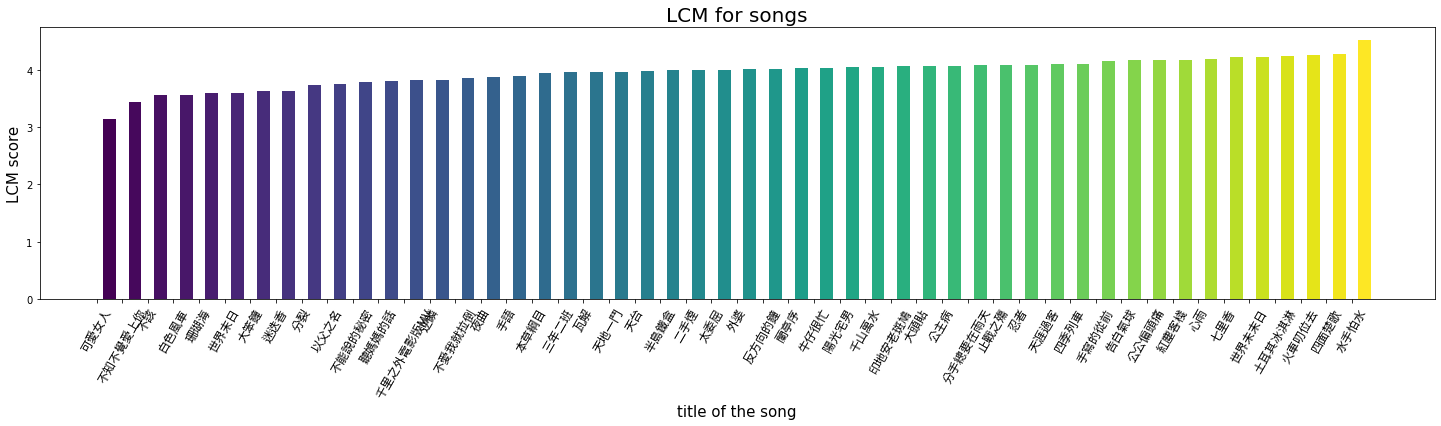

In [14]:
%matplotlib inline
from matplotlib import cm
plt.figure(figsize=(25,5))
plt.title('LCM for songs', fontsize = 20)
plt.xlabel('title of the song', fontsize = 15)
plt.ylabel('LCM score', fontsize = 15)
# matplotlib w/ Chinese is a pita: 
# use x first then change the xticks by inserting the text in certain intervals
x = range(len(Res))
width = 0.5
plt.xticks([(i-1)+width for i in x], Res['title'], fontproperties = myf, rotation = 60, fontsize = 12)
cmap = cm.viridis(np.linspace(0, 1, len(Res))) # cm: magma, jet, viridis... # https://bids.github.io/colormap/
plt.bar(x, Res['LCM score'], width, color = cmap)
plt.show()

**Exercise 2**

Bag of words 是用來做文本表徵最原始的其中一種方式，許多後續的表徵方式也從此延伸。這題我們將利用簡單的bag of words模型來探討歌曲之間的相似性。

請利用scikit learn 中的CountVectorizer將jay_50.csv中每首歌曲進行表徵後，計算每首歌曲之間的cosine similarity。

請注意:

CountVectorizer預設只會包含雙字以上的詞，請將單字詞也納入。另外請過濾掉只出現在一首歌裡的tokens(出現在兩首歌以上的token才納入)
你的code至少需要包含以下資訊：

1. 由CountVectorizer所產生的Document-term matrix
2. Pairwise similarity matrix
3. 由pairwise similarity產生的heatmap

ref: https://www.twblogs.net/a/5b81bc232b71772165ae0298

In [49]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
# 1. Use segmented texts
corpus = [' '.join(s) for s in WSes]
# 2. min-df = 2 to allow only tokens appear in 2 song or more, token-pattern: allow capturing one word
cv = CountVectorizer(min_df = 2, analyzer = 'word', token_pattern = r'(?u)\b\w+\b')
X = cv.fit_transform(corpus)

In [55]:
features = cv.get_feature_names()
df = pd.DataFrame.sparse.from_spmatrix(X, columns=features)
doc_term_mtrx = df.copy()
doc_term_mtrx.insert(loc = 0, column = 'title', value = lyrics_df['title'])
doc_term_mtrx

,title,一,一下,一切,一定,一樣,一生,一直,一起,一路,一點,上,上翹,下,下去,不,不停,不再,不同,不是,不會,不用,不能,不要,且,世界,並,中,久,之,之中,之前,之後,也,也許,乾脆,了,事,交給,人,...,靠,靠在,靠近,面,面前,面對,鞦韆,音樂,響,頁,預兆,顆,願意,風,風景,風聲,風鈴,飄,飄揚,飛,飛翔,首,馬,驕傲,驚喜,驟雨,高,高級,高興,魔法,鮮紅,鮮豔,鳥,鹹鹹,黑,黑夜,黑白,黑色,點,齣
0,世界未末日,0,0,2,0,0,0,0,0,2,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,6,0,0,3,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,外婆,2,0,0,0,0,0,0,0,0,0,2,0,0,0,7,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,大笨鐘,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,忍者,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,太委屈,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,3,0,0,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,千山萬水,5,0,0,0,0,0,0,2,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0
6,反方向的鐘,6,0,1,0,0,0,0,0,0,0,2,0,0,0,8,0,2,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,紅塵客棧,0,0,0,0,0,0,0,0,0,0,1,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,4,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,2,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,瓦解,2,0,0,0,0,0,1,0,0,0,0,0,1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,天涯過客,3,0,0,0,0,0,0,0,0,0,0,0,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,20,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
from sklearn.metrics.pairwise import cosine_similarity
csim_mtrx = cosine_similarity(df)
csim_df = pd.DataFrame(csim_mtrx, index = lyrics_df['title'])
csim_df = csim_df .rename(columns=lyrics_df['title'])
csim_df 

,世界未末日,外婆,大笨鐘,忍者,太委屈,千山萬水,反方向的鐘,紅塵客棧,瓦解,天涯過客,公主病,大頭貼,分裂,蘭亭序,牛仔很忙,火車叨位去,天地一鬥,不知不覺愛上你,四季列車,本草綱目,不該,陽光宅男,逆鱗,心雨,夜曲,聽媽媽的話,珊瑚海,分手總要在雨天,公公偏頭痛,土耳其冰淇淋,止戰之殤,世界末日,天台,手語,七里香,不愛我就拉倒,二手煙,四面楚歌,千里之外電影版MV,不能說的秘密,印地安老斑鳩,水手怕水,告白氣球,迷迭香,以父之名,三年二班,半島鐵盒,手寫的從前,可愛女人,白色風車
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
世界未末日,1.000000,0.486511,0.442689,0.420335,0.556352,0.532098,0.502906,0.313786,0.452989,0.376001,0.504492,0.488079,0.511368,0.236174,0.374168,0.240983,0.158925,0.424828,0.468923,0.374794,0.503204,0.473871,0.506704,0.437226,0.456611,0.490747,0.409494,0.378541,0.401860,0.449874,0.322376,0.457192,0.499241,0.511845,0.450679,0.483354,0.503008,0.483802,0.356634,0.510942,0.354345,0.428423,0.468100,0.392203,0.496594,0.518141,0.553481,0.475563,0.365990,0.389704
外婆,0.486511,1.000000,0.380067,0.573941,0.546535,0.479746,0.522290,0.400328,0.553884,0.332044,0.424997,0.453827,0.591774,0.297549,0.412262,0.241929,0.212208,0.394885,0.512883,0.490101,0.579585,0.431371,0.500031,0.670419,0.600903,0.676998,0.445041,0.301982,0.486801,0.459787,0.518689,0.478595,0.535168,0.481816,0.586315,0.456501,0.504266,0.658705,0.497153,0.588029,0.476731,0.434227,0.490472,0.525061,0.646731,0.520812,0.617757,0.590751,0.547144,0.414844
大笨鐘,0.442689,0.380067,1.000000,0.230461,0.688748,0.382356,0.526111,0.281370,0.372632,0.456880,0.743603,0.617507,0.540423,0.225084,0.332859,0.451383,0.268728,0.733235,0.594861,0.398016,0.409458,0.594260,0.491677,0.265819,0.382246,0.533851,0.359415,0.500940,0.392953,0.539808,0.139426,0.389071,0.604275,0.726523,0.345052,0.662467,0.590072,0.512667,0.281018,0.479763,0.444834,0.496311,0.514041,0.243158,0.286323,0.582570,0.650448,0.506952,0.290848,0.386816
忍者,0.420335,0.573941,0.230461,1.000000,0.403253,0.500244,0.533930,0.315564,0.534536,0.282588,0.356866,0.313421,0.461290,0.294202,0.321250,0.236420,0.262424,0.331680,0.492485,0.555571,0.465793,0.353400,0.410902,0.569614,0.617060,0.542129,0.287706,0.409218,0.423494,0.434165,0.478327,0.402045,0.351800,0.403279,0.610018,0.293012,0.456010,0.553341,0.438614,0.574670,0.475772,0.226412,0.490005,0.564047,0.660098,0.416828,0.485042,0.607550,0.512166,0.311073
太委屈,0.556352,0.546535,0.688748,0.403253,1.000000,0.474873,0.654838,0.356024,0.512969,0.483840,0.734279,0.548034,0.583297,0.295552,0.411422,0.373555,0.233074,0.714208,0.684945,0.457277,0.543923,0.646556,0.588841,0.491093,0.569573,0.674539,0.457794,0.508260,0.455897,0.564719,0.327863,0.482918,0.596354,0.728767,0.552981,0.678415,0.633993,0.581206,0.396860,0.639254,0.449411,0.441287,0.629592,0.489311,0.530715,0.579128,0.692467,0.582290,0.499537,0.434547
千山萬水,0.532098,0.479746,0.382356,0.500244,0.474873,1.000000,0.506642,0.335435,0.493522,0.250401,0.425251,0.401766,0.481070,0.372750,0.346097,0.278410,0.272788,0.436166,0.440489,0.507276,0.493534,0.414950,0.509670,0.428435,0.504693,0.502075,0.348418,0.317418,0.413002,0.465666,0.340466,0.501283,0.529188,0.453042,0.542948,0.377227,0.488149,0.549008,0.423517,0.516951,0.446594,0.422714,0.471163,0.434235,0.545033,0.483137,0.488984,0.538736,0.490507,0.438973
反方向的鐘,0.502906,0.522290,0.526111,0.533930,0.654838,0.506642,1.000000,0.320461,0.558525,0.383836,0.543082,0.464268,0.542451,0.290784,0.313101,0.350598,0.247087,0.586258,0.640901,0.474511,0.572587,0.464968,0.460017,0.583900,0.665789,0.636927,0.502185,0.471099,0.507279,0.505214,0.469290,0.480336,0.444090,0.630230,0.576490,0.597349,0.571583,0.495748,0.482170,0.675053,0.443704,0.434403,0.664061,0.546229,0.650230,0.560697,0.669906,0.641580,0.484884,0.370002
紅塵客棧,0.313786,0.400328,0.281370,0.315564,0.356024,0.335435,0.320461,1.000000,0.492834,0.338166,0.316871,0.289483,0.336879,0.544478,0.406138,0.153069,0.306302,0.298832,0.325690,0.306529,0.339078,0.250364,0.380671,0.384736,0.479204,0.374059,0.240154,0.212909,0.318522,0.289883,0.277368,0.376228,0.425745,0.302044,0.524463,0.244334,0.347771,0.493276,0.581004,0.341062,0.405135,0.324019,0.303522,0.458929,0.378137,0.319192,0.390112,0.361311,0.398524,0.569330
瓦解,0.452989,0.553884,0.372632,0.534536,0.512969,0.493522,0.55

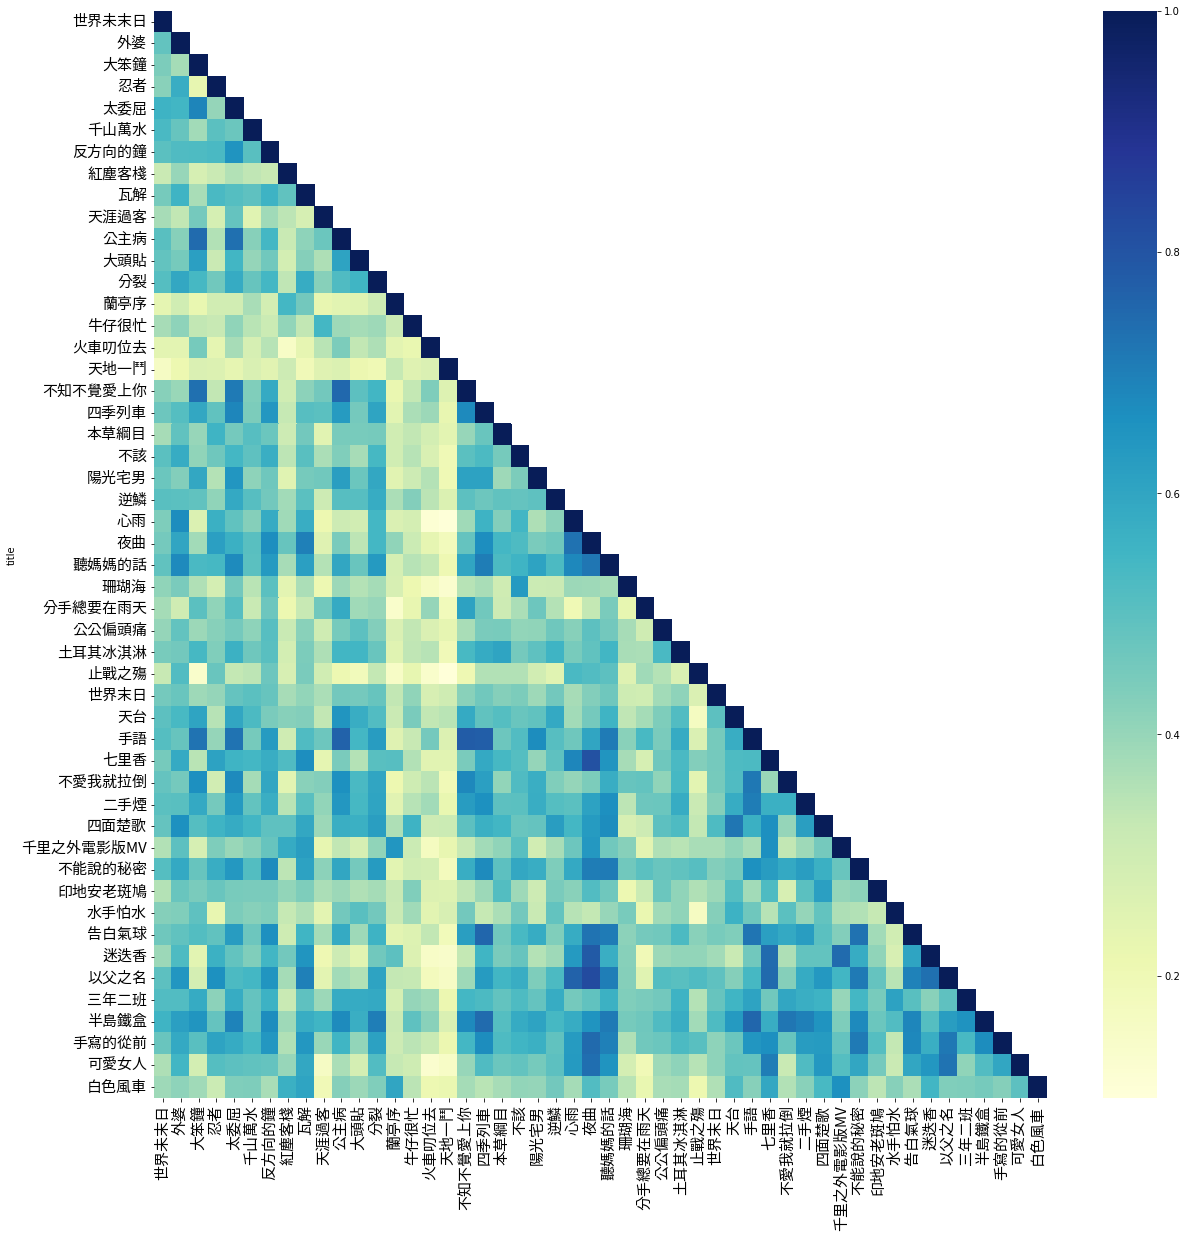

In [75]:
# ref: TA's visualization code https://github.com/ComputationalSemantics/python-warmup-exercise-Nana2929/blob/main/warmup_exercise_template.ipynb
# beautiful colormaps ref: https://blog.csdn.net/ztf312/article/details/102474190
import seaborn as sns
plt.figure(figsize = (20, 20))
plt.xticks(FontProperties = myf, fontsize=15)
plt.yticks(FontProperties = myf, fontsize=15)
mask = np.triu(np.ones_like(csim_df, dtype=bool), k = 1) # mask the upper trainglur matrix, k = 1 keeps the diagonal  
sns.heatmap(csim_df, cmap= 'YlGnBu', mask = mask) # sns.diverging_palette(230, 20, as_cmap=True)